In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 

In [2]:
dataset = pd.read_csv('CREDIT1.csv')
dataset

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
0,15776156,1,22.08,11.460,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,15739548,0,22.67,7.000,2,8,4,0.165,0,0,0,0,2,160,1,0
2,15662854,0,29.58,1.750,1,4,4,1.250,0,0,0,1,2,280,1,0
3,15687688,0,21.67,11.500,1,5,3,0.000,1,1,11,1,2,0,1,1
4,15715750,1,20.17,8.170,2,6,4,1.960,1,1,14,0,2,60,159,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,15808223,1,31.57,10.500,2,14,4,6.500,1,0,0,0,2,0,1,1
686,15769980,1,20.67,0.415,2,8,4,0.125,0,0,0,0,2,0,45,0
687,15675450,0,18.83,9.540,2,6,4,0.085,1,0,0,0,2,100,1,1
688,15776494,0,27.42,14.500,2,14,8,3.085,1,1,1,0,2,120,12,1


In [3]:
x = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

# Feature scaling

In [4]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
x_scaled = sc.fit_transform(x)

# Training the SOM

In [5]:
from minisom import MiniSom
som = MiniSom(x=10, y=10, input_len=15, sigma=1.0, learning_rate=0.5)
som.random_weights_init(x_scaled)
som.train_random(data=x_scaled, num_iteration=100)

# Visualize the results

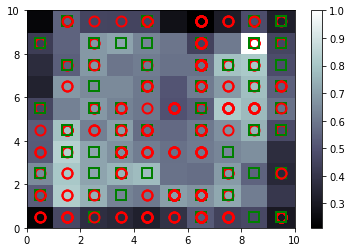

In [15]:
from pylab import bone, colorbar, pcolor, plot, show
bone()
pcolor(som.distance_map().T)
colorbar()
markers = ['o','s']
colors = ['r','g']

for i, j in enumerate(x_scaled):
    w = som.winner(j)
    plot(w[0] + 0.5,
         w[1] + 0.5,
         markers[y[i]],
         markeredgecolor = colors[y[i]],
         markerfacecolor = 'None',
         markersize = 10,
         markeredgewidth = 2)
show()

## Finding the frauds


In [13]:
mappings = som.win_map(x_scaled)
frauds = np.concatenate((mappings[(9,9)], mappings[(7,6)]), axis=0)
frauds = sc.inverse_transform(frauds)
for i in frauds[:, 0]:
  print(int(i))

15682540
15800773
15704509
15727811


# Part 2 - Supervised Deep Learning

## Matrix of features

In [18]:
customers = dataset.iloc[:, 1:].values
customers

array([[1.000e+00, 2.208e+01, 1.146e+01, ..., 1.000e+02, 1.213e+03,
        0.000e+00],
       [0.000e+00, 2.267e+01, 7.000e+00, ..., 1.600e+02, 1.000e+00,
        0.000e+00],
       [0.000e+00, 2.958e+01, 1.750e+00, ..., 2.800e+02, 1.000e+00,
        0.000e+00],
       ...,
       [0.000e+00, 1.883e+01, 9.540e+00, ..., 1.000e+02, 1.000e+00,
        1.000e+00],
       [0.000e+00, 2.742e+01, 1.450e+01, ..., 1.200e+02, 1.200e+01,
        1.000e+00],
       [1.000e+00, 4.100e+01, 4.000e-02, ..., 5.600e+02, 1.000e+00,
        1.000e+00]])

## Dependent variable

In [19]:
# a vector of zeros 
is_fraud = np.zeros(len(dataset))

In [23]:
# we add a 1 instead of a 0 if the customer was in the list of frauds
for i in range(len(dataset)):
    if dataset.iloc[i,0] in frauds:
        is_fraud[i] = 1
        

## Starting the ann

In [25]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
customers_scaled = sc.fit_transform(customers)

In [26]:
from keras.models import Sequential
from keras.layers import Dense

In [34]:
classifier = Sequential()
classifier.add(   
    Dense(units=2, kernel_initializer= 'uniform', activation='relu', input_dim=15),
)
classifier.add(
    Dense(units=1, kernel_initializer= 'uniform', activation='sigmoid')  
)

In [36]:
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [37]:
classifier.fit(x=customers_scaled, y=is_fraud, batch_size=1,epochs=2)

Epoch 1/2
690/690 [==============================] - 1s 744us/step - loss: 0.5678 - accuracy: 0.9836
Epoch 2/2
690/690 [==============================] - 1s 769us/step - loss: 0.1093 - accuracy: 0.9991


## Predicting the probabilities of fraud

In [54]:
prediction = classifier.predict(customers_scaled)
prediction = np.concatenate((dataset.iloc[:,0:1].values, prediction), axis=1)
prediction = prediction[prediction[:,1].argsort()]
prediction

array([[1.56214230e+07, 9.94071364e-03],
       [1.56458200e+07, 1.00966692e-02],
       [1.56826860e+07, 1.19604170e-02],
       ...,
       [1.55988020e+07, 2.61858165e-01],
       [1.57627160e+07, 2.73280650e-01],
       [1.57901130e+07, 3.32939595e-01]])